<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

https://github.com/Andrew-Wyn/ISPR_HWS/blob/master/MidTerm3_1/ISPR_HW3.ipynb

In [4]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [5]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

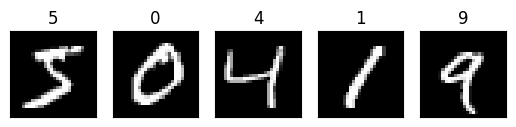

In [6]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

In [ ]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cpu


# Preparing the dataset

In [7]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train).item())
print("Min:", torch.min(X_train).item())

Max: 1.0
Min: 0.0


The implementation chosen for this assignment is a **denoising autoencoder**, so below a method for adding noise to images is implemented

In [8]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

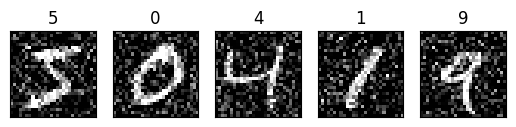

In [9]:
noise_std = 0.3
X_train_noisy = add_noise(X_train[:5], 0, noise_std)
plot_example(X_train_noisy, y_train)

In [10]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=20)

# Utils

In [11]:
import torch.nn as nn
import torch.nn.functional as F

encoding_dim = 32
criterion = nn.MSELoss()
epochs=20

In [ ]:
def fit(epochs, model, criterion, train_loader, optimizer):
  history = []

  for epoch in range(1, epochs+1):
    train_loss=0.0

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      loss = criterion(output, images)

      # optimizer step and backward pass
      loss.backward()
      optimizer.step()

      train_loss += loss.item()*images.size(0)
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    history.append(train_loss)
    
  return history

In [ ]:
def evaluate(model, data, criterion):
  X_test_noisy = add_noise(data, 0, noise_std)
  with torch.no_grad():
    output = model(X_test_noisy)
    loss = criterion(output, data) 

  return loss, X_test_noisy, output

In [ ]:
def check_results(input, denoised, original, label):
  # show images and their reconstruction
  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 10))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item(), fontsize=20) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=20)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=20)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=20)
  
  plt.show()

# Single Layer Autoencoder

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, enc_dim):
    super(Autoencoder, self).__init__()
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.dense1 = nn.Linear(input_dim, enc_dim)

    # the decoder will reconstruct the image in the original space
    self.dense2 = nn.Linear(enc_dim, input_dim)
   
  def forward(self, x):
    # encoding
    x = F.relu(self.dense1(x))
  
    # decoding
    x = F.sigmoid(self.dense2(x))
    return x
  
  # return the encode of the input - used for deep AE with layerwise pretraining
  def get_encoder(self, x):
    x = F.relu(self.dense1(x))
    return x
  
  # return the decoding of the latent space - used for deep AE with layerwise pretraining
  def get_decoder(self, x):
    x = F.sigmoid(self.dense2(x))
    return x

In [ ]:
model = Autoencoder(X_train.shape[1], encoding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = fit(epochs, model, criterion, train_loader, optimizer)

Epoch: 1 	Training Loss: 0.716041212528944
Epoch: 2 	Training Loss: 0.47679178070276973
Epoch: 3 	Training Loss: 0.46180342805882296
Epoch: 4 	Training Loss: 0.4559046070526044
Epoch: 5 	Training Loss: 0.4520313224258522
Epoch: 6 	Training Loss: 0.4488810024037957
Epoch: 7 	Training Loss: 0.4461043173757692
Epoch: 8 	Training Loss: 0.4440011969767511
Epoch: 9 	Training Loss: 0.4420594193165501
Epoch: 10 	Training Loss: 0.44048874521628023
Epoch: 11 	Training Loss: 0.43911667179937164
Epoch: 12 	Training Loss: 0.43832370849947133
Epoch: 13 	Training Loss: 0.43702506336693964
Epoch: 14 	Training Loss: 0.43634037680303056
Epoch: 15 	Training Loss: 0.4355299234452347
Epoch: 16 	Training Loss: 0.4349970082566142
Epoch: 17 	Training Loss: 0.4346157638604442
Epoch: 18 	Training Loss: 0.4342048427090049
Epoch: 19 	Training Loss: 0.43364276487380266
Epoch: 20 	Training Loss: 0.4336681215837598


In [ ]:
loss, noisy_data, denoised = evaluate(model, X_test, criterion)
print("Single layer AutoEncoder loss:", loss.item())

Single layer AutoEncoder loss: 0.021166091784834862


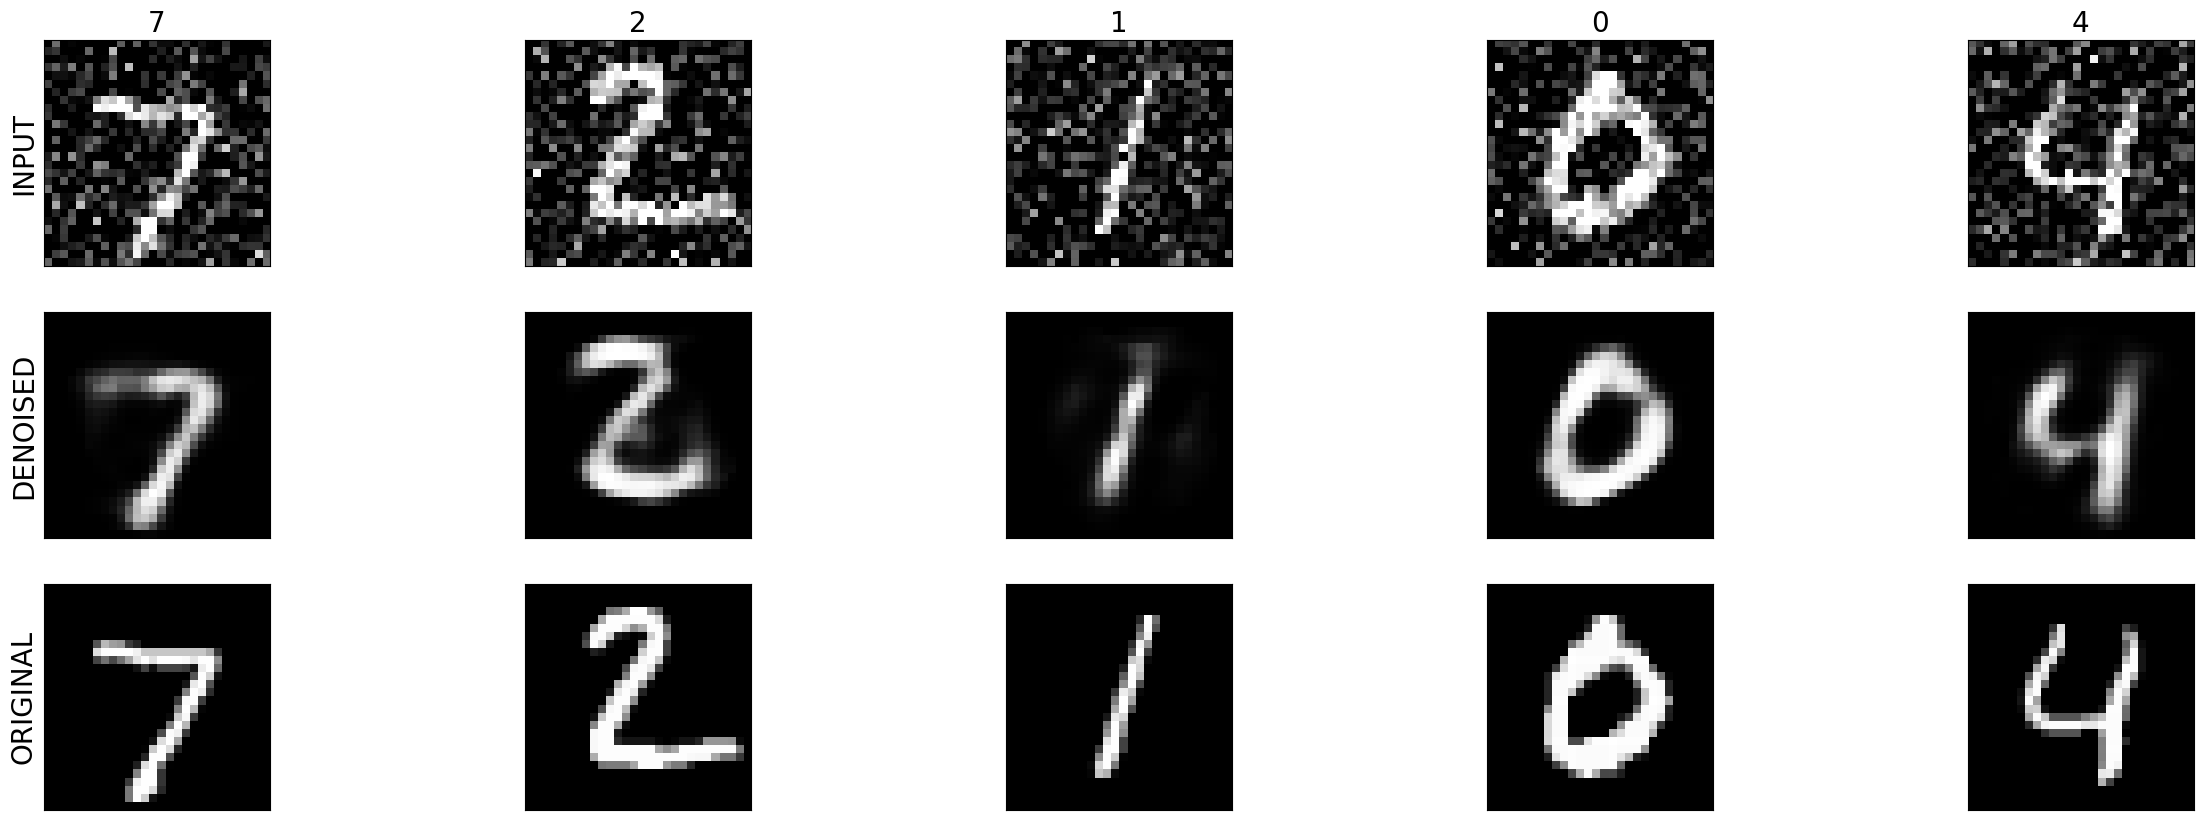

In [ ]:
check_results(noisy_data, denoised, X_test, y_test)

# Deep AutoEncoder with only layerwise pretraining

https://www.kaggle.com/code/baogorek/autoencoder-with-greedy-layer-wise-pretraining/notebook

https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

In [ ]:
layers=3

In [ ]:
# use single layer AE class to build the deep autoencoder
# in this implementation all the hidden layers have the same dimension

# append first layer
autoencoders = [Autoencoder(X_train.shape[1], encoding_dim)]

# hidden
for i in range(layers-1):
  autoencoders.append(Autoencoder(encoding_dim, encoding_dim))
    
train_loader_first = train_loader

print(train_loader_first)

for ae in autoencoders:
  optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
  history = fit(epochs, ae, criterion, train_loader, optimizer)
  encoding = ae.get_encoder
  train_loader = torch.utils.data.DataLoader(encoding, batch_size=20)
  print(train_loader)

# last layer for decoding
decoder = Autoencoder(encoding_dim, X_train.shape[1])
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
history = fit(epochs, decoder, criterion, train_loader, optimizer)

Epoch: 1 	Training Loss: 0.7721840297679107
Epoch: 2 	Training Loss: 0.537707352998356
Epoch: 3 	Training Loss: 0.5242643078292409
Epoch: 4 	Training Loss: 0.5179259733979901
Epoch: 5 	Training Loss: 0.5138109305004279
Epoch: 6 	Training Loss: 0.510106420814991
Epoch: 7 	Training Loss: 0.5069579031566779
Epoch: 8 	Training Loss: 0.5041015775874257
Epoch: 9 	Training Loss: 0.5015211618940035
Epoch: 10 	Training Loss: 0.49949169121682646
Epoch: 11 	Training Loss: 0.4976816622292002
Epoch: 12 	Training Loss: 0.49655547878394524
Epoch: 13 	Training Loss: 0.4952722942456603
Epoch: 14 	Training Loss: 0.4945905819411079
Epoch: 15 	Training Loss: 0.49365028193841376
Epoch: 16 	Training Loss: 0.49307019634793203
Epoch: 17 	Training Loss: 0.4924740850056211
Epoch: 18 	Training Loss: 0.49188450470566747
Epoch: 19 	Training Loss: 0.49153790491322674
Epoch: 20 	Training Loss: 0.4911811094606916


TypeError: ignored